# #3. OOP

## Motivation

__Goal__

Выработать прагматичный и идиоматичный взгляд на использование ООП в Python, разобраться с основными структурными блоками и понятиями объектной модели языка

__Homework__

Scoring API

## Object model

__OOP__:
* Delegation
    * let someone else do work
* Polymorphism
    * act "as-if" someone else
* Instantiation
    * "blueprint"

__OOP in Python__:
* Everything is an object
* Everything is a reference
* Objects just bunch of dicts
* class statement executes suite
    * separate namespace (dict)
* class object created from dict
    * namespace becomes attribute space
* methods are just functions

In [34]:
def f():
    return 42

class SomeClass:
    classattr = f()
    def method(self, arg):
        self.instanceattr = arg
    def helper(arg):
        return arg + 1
    for i in range(10):
        classattr = helper(classattr)
    del helper

SomeClass.__dict__

mappingproxy({'__module__': '__main__',
              'classattr': 52,
              'method': <function __main__.SomeClass.method(self, arg)>,
              'i': 9,
              '__dict__': <attribute '__dict__' of 'SomeClass' objects>,
              '__weakref__': <attribute '__weakref__' of 'SomeClass' objects>,
              '__doc__': None})

The `mappingproxy` is used to ensure that the keys in a `class.__dict__` are always strings, allowing for a number of optimisations in the Python interpreter. The proxy prevents writing to `class.__dict__`, so only `setattr()` can be used, and the `class.__setattr__` implementation enforces the keys-must-be-strings limitation

Class creation involves roughly the following processes:
* The body of the class statement is isolated into a code object.
* The appropriate metaclass for class instantiation is determined.
* A class dictionary representing the namespace for the class is prepared.
* The code object representing the body of the class is executed within this namespace.
* The class object is created.

In [3]:
dir(SomeClass())

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'classattr',
 'i',
 'method']

__Python Object__
* all data in instance attributes stored in \__dict\__
* referer to class stored in \__class\__
* attributes that define special behaviour stored in \__\*\__ methods
* no type check
    * isinstance, issubclass
* function become methods (Objects/methodobject.c: PyCFunction_Call)
    * by magic

In [3]:
import inspect

class C:
    def foo(self):
        pass

print(C.foo) # C.__dict__['foo'].__get__(None, C)
print(C.__dict__['foo'])

print(inspect.isfunction(C.foo))
print(inspect.ismethod(C.foo))

c = C()
print(c.__dict__)
print(c.foo) # c.__getattribute__('foo') -> C.__dict__['foo'].__get__(c, C)
print(c.foo(), C.foo(c))

<function C.foo at 0x1068179d0>
<function C.foo at 0x1068179d0>
True
False
{}
<bound method C.foo of <__main__.C object at 0x1057a7f40>>
None None


#### New style

* low-level constructors named \_\_new\_\_()
* descriptors, a generalized way to customize attribute access
* static methods and class methods
* properties (computed attributes)
* decorators (introduced in Python 2.4)
* slots
* a new Method Resolution Order (MRO)

In [9]:
class Classic:
    def method(cls):
        pass

print Classic.__mro__
    
class New(object):
    def method(self):
        pass
print New.__mro__

AttributeError: class Classic has no attribute '__mro__'

#### MRO

In [62]:
class X(object): pass
class Y(object): pass
class A(X, Y): pass
class B(Y, X): pass

class C(A, B): pass

TypeError: Error when calling the metaclass bases
    Cannot create a consistent method resolution
order (MRO) for bases X, Y

In [63]:
B.__mro__

(__main__.B, __main__.Y, __main__.X, object)

In [71]:
class Old: pass
class O1(Old): pass
class O2(Old): pass
class OD(O1, O2): pass
# OD, O1, Old, O2, Old

class New(object): pass
class N1(New): pass
class N2(New): pass
class ND(N1, N2): pass
ND.__mro__
# ND, N1, New, object, N2, New, object

(__main__.ND, __main__.N1, __main__.N2, __main__.New, object)

In Python every class declaration should be read as a single partial order: `class A(B, C)` should be understood to mean that A < B < C

In [4]:
class A(object):
    def __init__(self):
        print "I'm from A"

class B(A):
    def __init__(self):
        print "I'm from B"
        super(B, self).__init__()  

class C(A):
    def __init__(self):
        print "I'm from C"
        super(C, self).__init__()

class D(B, C):
    def __init__(self):
        print "I'm from D"
        super(D, self).__init__()
d = D()

I'm from D
I'm from B
I'm from C
I'm from A


#### super

super() is in the business of delegating method calls to some class in the __instance’s__ ancestor tree
* the method being called by super() needs to exist
    * write a root class
* the caller and callee need to have a matching argument signature
    * use kwargs
* and every occurrence of the method needs to use super()

Before `super()` was introduced, we would have hardwired the call with `dict.__setitem__(self, key, value)`. However, `super()` is better because it is a computed indirect reference.

In [4]:
import collections
import logging

logging.basicConfig(level='INFO')

class LoggingDict(dict):
    def __setitem__(self, key, value):
        logging.info('Setting %r to %r' % (key, value))
        super(LoggingDict, self).__setitem__(key, value)

class LoggingOD(LoggingDict, collections.OrderedDict):
    # Build new functionality by reordering the MRO
    pass

ld = LoggingDict([('red', 1), ('green', 2), ('blue', 3)])
print(ld)
ld['red'] = 10

ld = LoggingOD([('red', 1), ('green', 2), ('blue', 3)])
print(ld)
ld['red'] = 10

INFO:root:Setting 'red' to 10
INFO:root:Setting 'red' to 1
INFO:root:Setting 'green' to 2
INFO:root:Setting 'blue' to 3
INFO:root:Setting 'red' to 10


{'red': 1, 'green': 2, 'blue': 3}
LoggingOD([('red', 1), ('green', 2), ('blue', 3)])


In [37]:
class Root:
    def draw(self):
        assert not hasattr(super(Root, self), 'draw')

class Shape(Root):
    def __init__(self, shapename, **kwds):
        self.shapename = shapename
        super().__init__(**kwds)
    def draw(self):
        print(f'Drawing.  Setting shape to: {self.shapename}')
        super().draw()

class ColoredShape(Shape):
    def __init__(self, color, **kwds):
        self.color = color
        super().__init__(**kwds)
    def draw(self):
        print(f'Drawing.  Setting color to: {self.color}')
        super().draw()
        
cs = ColoredShape(color='blue', shapename='square')
cs.draw()

Drawing.  Setting color to: blue
Drawing.  Setting shape to: square


#### Multiple inheritance

In [ ]:
class SingleObjectMixin(ContextMixin):
    """
    Provides the ability to retrieve a single object for further manipulation.
    """
    model = None
    queryset = None
    slug_field = 'slug'
    context_object_name = None
    slug_url_kwarg = 'slug'
    pk_url_kwarg = 'pk'
    query_pk_and_slug = False
    
    # methods and stuff

class BaseDetailView(SingleObjectMixin, View):
    """
    A base view for displaying a single object
    """
    def get(self, request, *args, **kwargs):
        self.object = self.get_object()
        context = self.get_context_data(object=self.object)
        return self.render_to_response(context)

As alternative to (multiple) inheritance you could consider composition in form of Strategy pattern (Behavioural pattern)

In [7]:
class ImageFinder:
    """ 
    In this example the base object ImageFinder keeps a copy
    of the concrete class (strategy).  You may also set
    a default strategy to use which might be convienient.
    In this case it is set to None which forces the caller
    to supply a concrete class.
        
    The concrete find method is supplied with an instance of
    this object so its state can be tracked.
    """
    
    def __init__(self, strategy=None):
        self.action = None
        self.count = 0
        if strategy:
            #get a handle to the object
            self.action = strategy()
    
    def find(self, image):
        if(self.action):
            self.count += 1
            return self.action.find(image, self)
        else: 
            raise UnboundLocalError('Exception raised, no strategyClass supplied to ImageFinder!')

class ImageFinderFlickr(object):
    ''' Locates images in Flickr. '''

    def find(self, image, instance):
        # in reality, query Flickr API for image path
        return "Found image in Flickr: " + image + ", search #" + str(instance.count)


class ImageFinderDatabase(object):
    ''' Locates images in database. '''
    def find(self, image, instance):
        #in reality, query database for image path
        return "Found image in database: " + image + ", search #" + str(instance.count)

#### Slots

Implements Flyweight pattern (Structural pattern) by suppressing instance `dict`. Use `__slots__` strictly, only to save memory (classes with LOTS of tiny instances)

In [39]:
class Circle:
    """An advvanced circle analytics toolkit"""
    __slots__ = ['radius', 'attr']

    def __init__(self, radius):
        self.radius = radius
        self.attr = 41

    def area(self):
        "Perform quadrature on shape of unofrm radius"
        p = self.__perimeter()
        r = p / math.pi / 2.0
        return math.pi * r ** 2.0

    def perimeter(self):
        "Return the perimeter"
        return 2.0 * math.pi * self.radius
    __perimeter = perimeter


c = Circle(23)
c.attr = 42
c.radius = 43
c.not_slot_attr = 43
print(c.__dict__) # AttributeError: 'Circle' object has no attribute '__dict__'

AttributeError: 'Circle' object has no attribute 'not_slot_attr'

#### new

`__init__` is not a constructor but just a mere initializer, object is already created by `__init__` time. `__new__` constructs new object.

In [11]:
class StandardClass:
    def __init__(self, x):
        self.x = x

newed_up_standard = object.__new__(StandardClass)
print(type(newed_up_standard) is StandardClass)
print(hasattr(newed_up_standard, 'x'))


StandardClass.__init__(newed_up_standard, 5)
print(newed_up_standard.x == 5)

True
False
True


In [89]:
def instantiate(cls, *args, **kwargs):
    obj = cls.__new__(cls, *args, **kwargs)
    if isinstance(obj, cls):
        cls.__init__(obj, *args, **kwargs)
    return obj

In [26]:
class Singleton:
    def __new__(cls, *a, **k):
        if not hasattr(cls, '_inst'):
            cls._inst = super(Singleton, cls).__new__(cls, *a, **k)
        return cls._inst

#### Name mangling

Double underscore (class local reference) is not for privacy. It's for refering to self.

In [12]:
import math

class Circle:
    """An advanced circle analytics toolkit"""
    __slots__ = ['diameter']

    def __init__(self, radius):
        self.radius = radius

    def area(self):
        "Perform quadrature on shape of unofrm radius"
        p = self.__perimeter()
        r = p / math.pi / 2.0
        return math.pi * r ** 2.0

    def perimeter(self):
        "Return the perimeter"
        return 2.0 * math.pi * self.radius
    __perimeter = perimeter

    
class Tire(Circle):
    "Tires are circles with a corrected perimiter"

    def perimeter(self):
        "Circumference corrected for the rubber"
        return Circle.perimeter(self) * 1.25

t = Tire(23)
print(dir(t), t.__dict__)
print(t.radius)
print(t.area())
print(t.perimeter())

['_Circle__perimeter', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', 'area', 'diameter', 'perimeter', 'radius'] {'radius': 23}
23
1661.9025137490005
180.6415775814131


#### Introspection

In [13]:
o = object()
[(a,type(o.__getattribute__(a))) for a in dir(o)]

[('__class__', type),
 ('__delattr__', method-wrapper),
 ('__dir__', builtin_function_or_method),
 ('__doc__', str),
 ('__eq__', method-wrapper),
 ('__format__', builtin_function_or_method),
 ('__ge__', method-wrapper),
 ('__getattribute__', method-wrapper),
 ('__gt__', method-wrapper),
 ('__hash__', method-wrapper),
 ('__init__', method-wrapper),
 ('__init_subclass__', builtin_function_or_method),
 ('__le__', method-wrapper),
 ('__lt__', method-wrapper),
 ('__ne__', method-wrapper),
 ('__new__', builtin_function_or_method),
 ('__reduce__', builtin_function_or_method),
 ('__reduce_ex__', builtin_function_or_method),
 ('__repr__', method-wrapper),
 ('__setattr__', method-wrapper),
 ('__sizeof__', builtin_function_or_method),
 ('__str__', method-wrapper),
 ('__subclasshook__', builtin_function_or_method)]

In [14]:
import inspect
print(inspect.getmembers(object))

[('__class__', <class 'type'>), ('__delattr__', <slot wrapper '__delattr__' of 'object' objects>), ('__dir__', <method '__dir__' of 'object' objects>), ('__doc__', 'The base class of the class hierarchy.\n\nWhen called, it accepts no arguments and returns a new featureless\ninstance that has no instance attributes and cannot be given any.\n'), ('__eq__', <slot wrapper '__eq__' of 'object' objects>), ('__format__', <method '__format__' of 'object' objects>), ('__ge__', <slot wrapper '__ge__' of 'object' objects>), ('__getattribute__', <slot wrapper '__getattribute__' of 'object' objects>), ('__gt__', <slot wrapper '__gt__' of 'object' objects>), ('__hash__', <slot wrapper '__hash__' of 'object' objects>), ('__init__', <slot wrapper '__init__' of 'object' objects>), ('__init_subclass__', <built-in method __init_subclass__ of type object at 0x103455250>), ('__le__', <slot wrapper '__le__' of 'object' objects>), ('__lt__', <slot wrapper '__lt__' of 'object' objects>), ('__ne__', <slot wrap

### References

* https://habrahabr.ru/post/114576/
* https://www.youtube.com/watch?v=E_kZDvwofHY
* https://www.youtube.com/watch?v=HTLu2DFOdTg
* https://www.youtube.com/watch?v=miGolgp9xq8
* https://www.youtube.com/watch?v=VOzvpHoYQoo
* http://python-history.blogspot.ru/2010/06/inside-story-on-new-style-classes.html
* https://www.python.org/download/releases/2.3/mro/
* https://rhettinger.wordpress.com/2011/05/26/super-considered-super/
* https://www.ibm.com/developerworks/library/l-pyint/
* https://pymotw.com/2/inspect/
* http://www.laurencegellert.com/2011/08/python-strategy-pattern/

### Summary

* use only new-style
* avoid complex class hierarchies
* use super() for delegation
* customize classs creation with \__new\__

## Descriptors

* key infrastructure for OOP in Python
* attribute access (get, set, delete)
    * search class/superclass dicts for name
    * delegate to descriptor if found
* all descriptors have method \__get\__
    * non-data descriptors
* if also has \__set\__, data descriptor 
    * > #define PyDescr_IsData(d) (Py_TYPE(d)->tp_descr_set != NULL)

#### Protocol

In [ ]:
descr.__get__(self, obj, type=None) --> value
descr.__set__(self, obj, value) --> None
descr.__delete__(self, obj) --> None
descr.__set_name__(self, owner, name) --> None

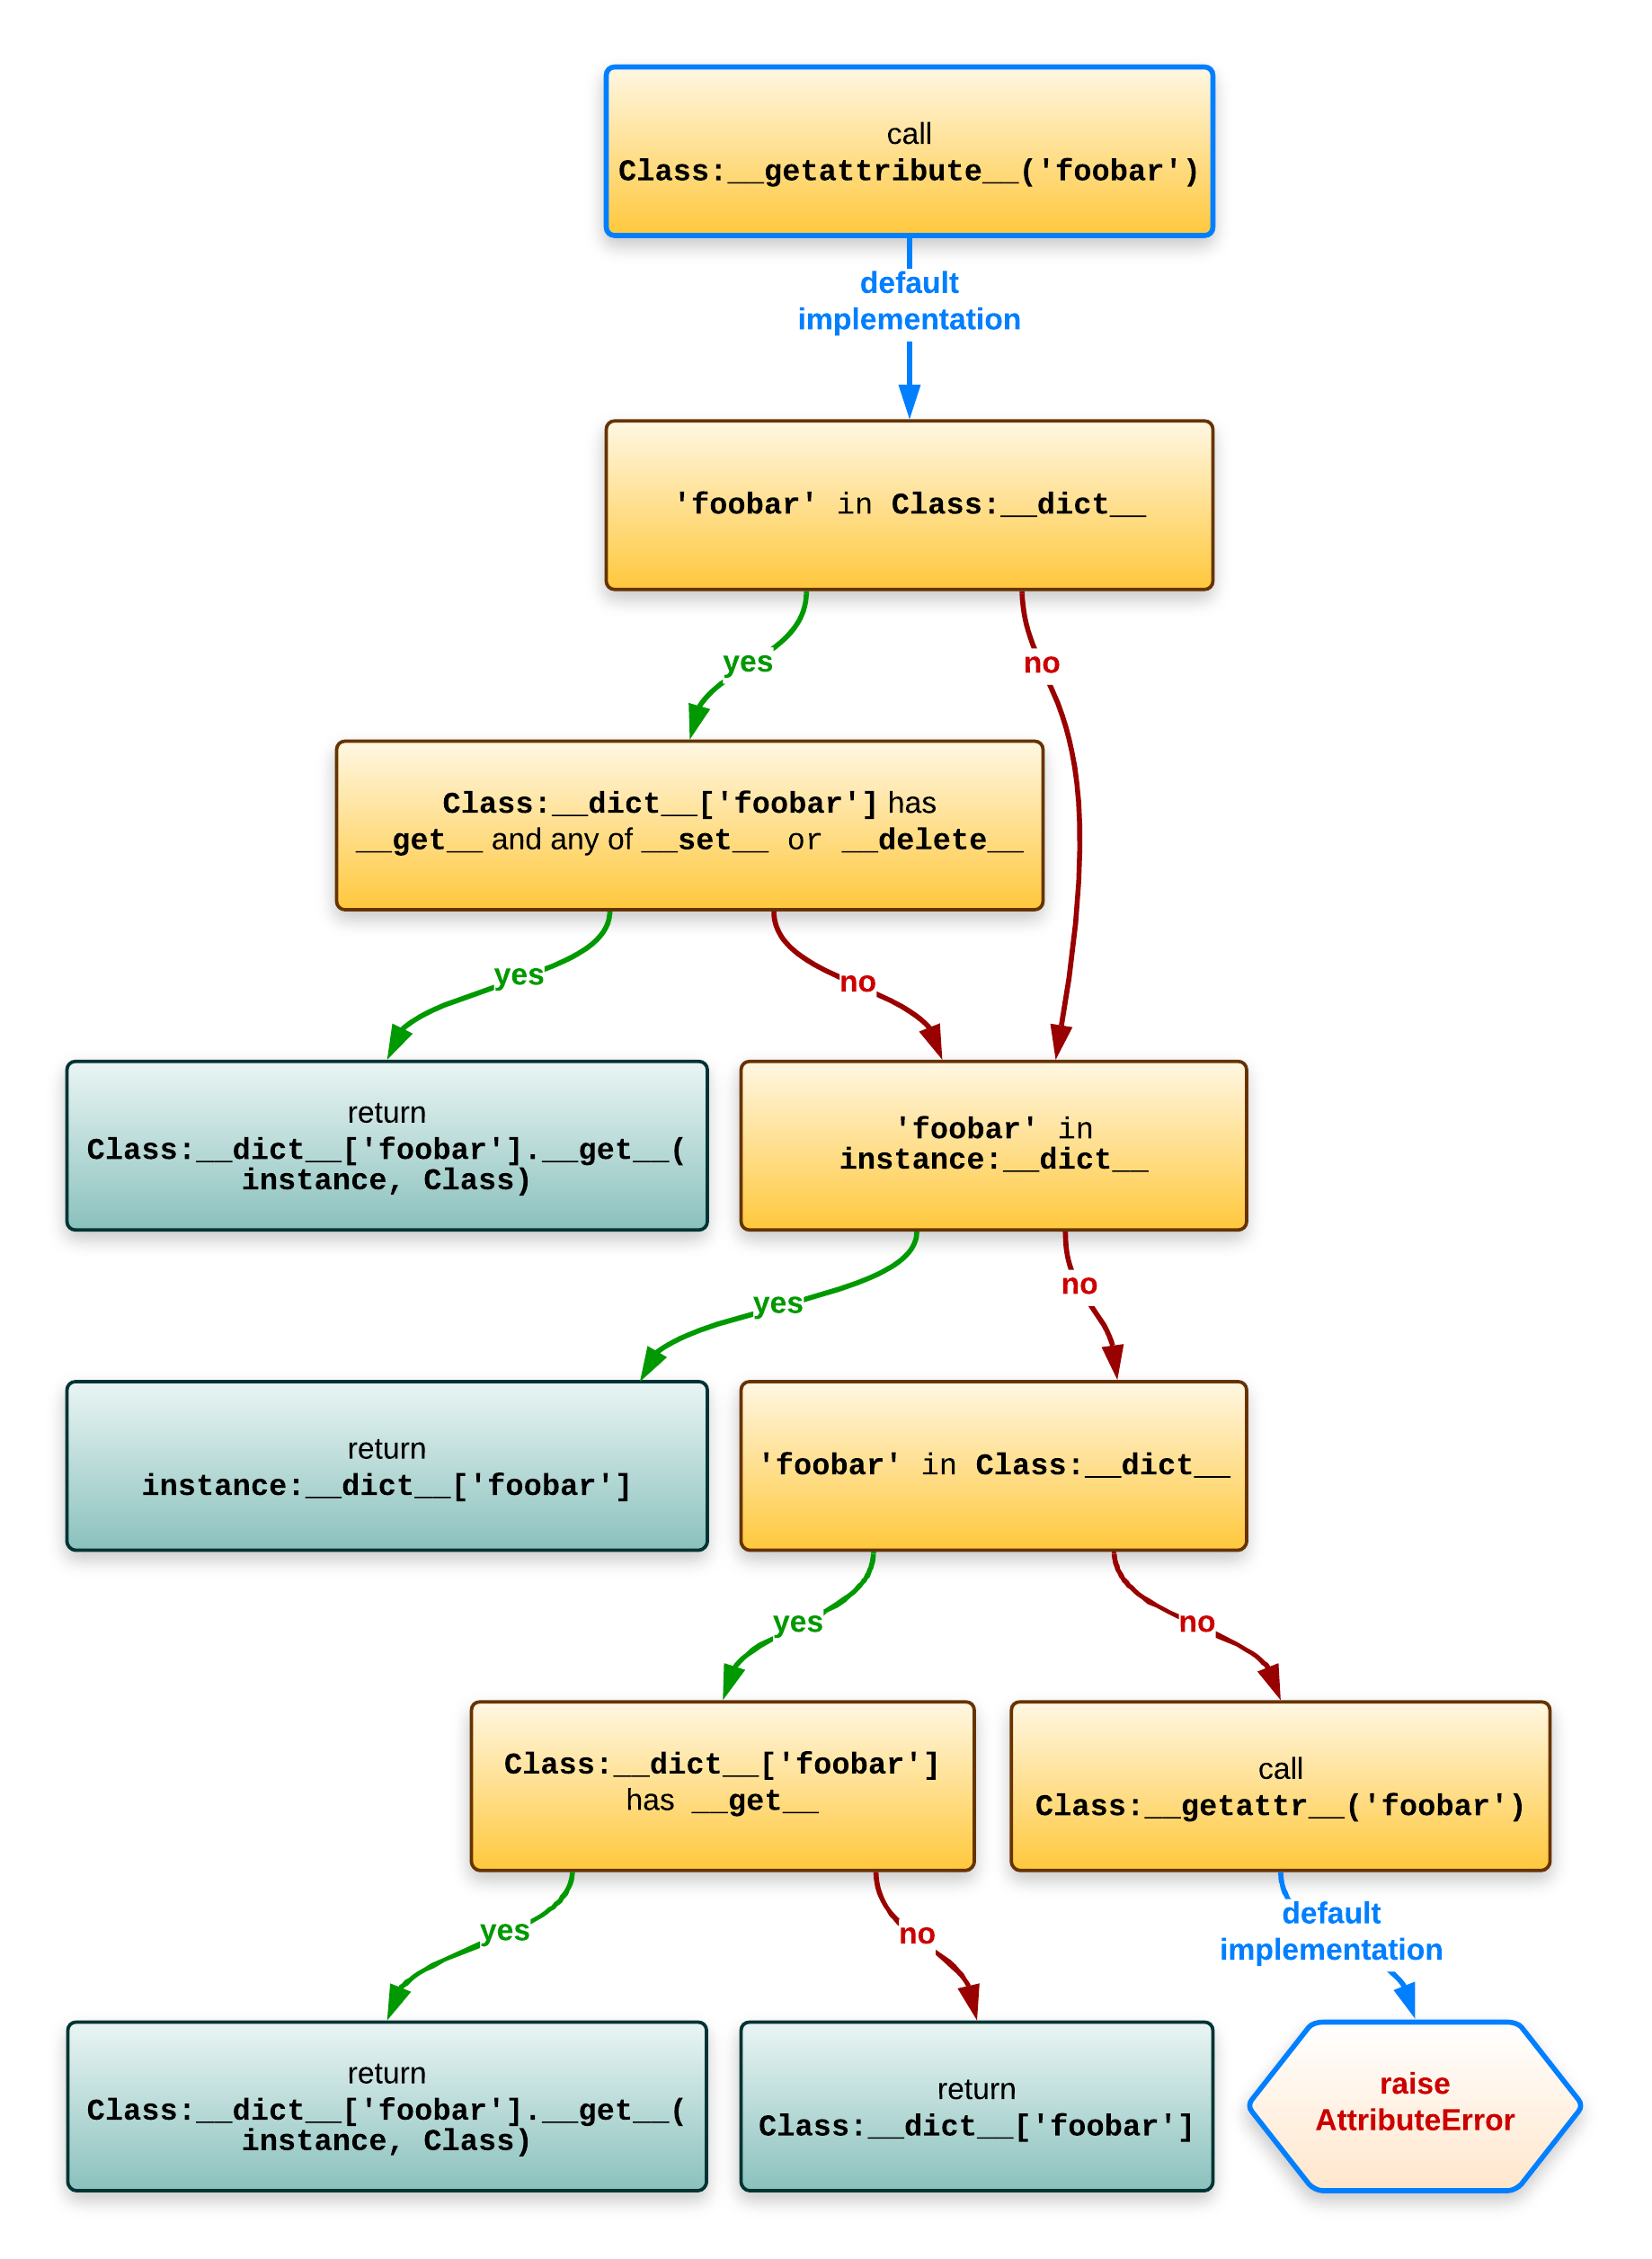

In [16]:
x = C()
print(x.foo)

def lookup(obj, attr):
    obj_cls = obj.__class__
    if hasattr(obj_cls, attr):
        d = getattr(obj_cls, attr)
        desc_cls = d.__class__
        if hasattr(desc_cls, '__get__') and (hasattr(desc_cls, '__set__') or attr not in obj.__dict__):
            return desc_cls.__get__(d, obj, obj_cls)
    return obj.__dict__[attr]

print(lookup(x, 'foo'))

<bound method C.foo of <__main__.C object at 0x106832fa0>>
<bound method C.foo of <__main__.C object at 0x106832fa0>>


In [28]:
x = C()
x.foo = 23

def setup(obj, attr, val):
    obj_cls = obj.__class__
    if hasattr(obj_cls, attr):
        d = getattr(obj_cls, attr)
        desc_cls = d.__class__
        if hasattr(desc_cls, '__set__'):
            desc_cls.__set__(d, obj, val)
        return
    obj.__dict__[attr] = val

Descriptors everywhere. Functions are descriptors too

In [17]:
def adder(x, y): return x + y
add23 = adder.__get__(23) # 23.adder
print(add23, adder)
print(add23(100))

<bound method adder of 23> <function adder at 0x106833c10>
123


Call `obj.f(*a, **k)` can be split into two parts: `(obj.f)(*a, **k)`

`(obj.f)` is `f.__get__(obj) `returning methodobject which is bound to `obj`.

then `methodobject(*a, **k)` called with `obj`(=self) passed  as first argument

Examples:

In [25]:
class cached_property:
    def __init__(self, func):
        self.func = func

    def __get__(self, obj, cls):
        print("Setting val to dict")
        value = obj.__dict__[self.func.__name__] = self.func(obj)
        return value

class Shape:
    @cached_property
    def area(self):
        value = 42
        return value

s = Shape()
print(s.__dict__)
print("First call:")
print(s.area)
print("Second call:")
print(s.__dict__, s.area)

{}
First call:
Setting val to dict
42
Second call:
{'area': 42} 42


In [27]:
class TypedProperty:

    def __init__(self, name, type, default=None):
        self.name = "_" + name
        self.type = type
        self.default = default if default else type()

    def __get__(self, instance, cls):
        return getattr(instance, self.name, self.default)

    def __set__(self, instance, value):
        if not isinstance(value, self.type):
            raise TypeError("Must be a %s" % self.type) 
        setattr(instance, self.name, value)

    def __delete__(self,instance):
        raise AttributeError("Can't delete attribute")


class Foo(object):
    name = TypedProperty("name", str) 
    num = TypedProperty("num", int, 42)

acct = Foo()
acct.name = "obi"
acct.num = 1234
print(acct.num)
print(acct.name)
acct.num = '1234'

1234
obi


TypeError: Must be a <class 'int'>

#### property

properties provide a concise way of adding data descriptors to attributes in Python

In [ ]:
property(fget=None, fset=None, fdel=None, doc=None) -> property attribute

In [37]:
class Accout:
    def __init__(self):
        self._acct_num = None

    def get_acct_num(self):
        return self._acct_num

    def set_acct_num(self, value):
        self._acct_num = value

    def del_acct_num(self):
        del self._acct_num

    acct_num = property(get_acct_num, set_acct_num, del_acct_num, "Account number property.")

In [38]:
class Property:
    "Emulate PyProperty_Type() in Objects/descrobject.c"

    def __init__(self, fget=None, fset=None, fdel=None, doc=None):
        self.fget = fget
        self.fset = fset
        self.fdel = fdel
        if doc is None and fget is not None:
            doc = fget.__doc__
        self.__doc__ = doc

    def __get__(self, obj, objtype=None):
        if obj is None:
            return self
        if self.fget is None:
            raise AttributeError("unreadable attribute")
        return self.fget(obj)

    def __set__(self, obj, value):
        if self.fset is None:
            raise AttributeError("can't set attribute")
        self.fset(obj, value)

    def __delete__(self, obj):
        if self.fdel is None:
            raise AttributeError("can't delete attribute")
        self.fdel(obj)

    def getter(self, fget):
        return type(self)(fget, self.fset, self.fdel, self.__doc__)

    def setter(self, fset):
        return type(self)(self.fget, fset, self.fdel, self.__doc__)

    def deleter(self, fdel):
        return type(self)(self.fget, self.fset, fdel, self.__doc__)

In [39]:
class C:
    def __init__(self):
        self._x = None

    @property
     # the x property. the decorator creates a read-only property
    def x(self):
        return self._x

    @x.setter
    # the x property setter makes the property writeable
    def x(self, value):
        self._x = value

    @x.deleter
    def x(self):
        del self._x

*BAD* example:

In [41]:
class Movie:
    def __init__(self, title, rating, runtime, budget, gross):
        self._rating = None
        self._runtime = None
        self._budget = None
        self._gross = None

        self.title = title
        self.rating = rating
        self.runtime = runtime
        self.gross = gross
        self.budget = budget
        
    #nice
    @property
    def budget(self):
        return self._budget
    
    @budget.setter
    def budget(self, value):
        if value < 0:
            raise ValueError("Negative value not allowed: %s" % value)
        self._budget = value
        
    #ok    
    @property
    def rating(self):
        return self._rating
    
    @rating.setter
    def rating(self, value):
        if value < 0:
            raise ValueError("Negative value not allowed: %s" % value)
        self._rating = value
       
    #uhh...
    @property
    def runtime(self):
        return self._runtime
    
    @runtime.setter
    def runtime(self, value):
        if value < 0:
            raise ValueError("Negative value not allowed: %s" % value)
        self._runtime = value        
    
    #is this forever?
    @property
    def gross(self):
        return self._gross
    
    @gross.setter
    def gross(self, value):
        if value < 0:
            raise ValueError("Negative value not allowed: %s" % value)
        self._gross = value        
        
    def profit(self):
        return self.gross - self.budget

*MUCH* better:

In [31]:
from weakref import WeakKeyDictionary

class NonNegative:
    """A descriptor that forbids negative values"""
    def __init__(self, default):
        self.default = default
        # prevent a memory leak -- we don't want an instance to stay alive 
        # simply because it's in the descriptor dictionary, and otherwise unused.
        self.data = WeakKeyDictionary()
        
    def __get__(self, instance, owner):
        # we get here when someone calls x.d, and d is a NonNegative instance
        # instance = x
        # owner = type(x)
        return self.data.get(instance, self.default)
    
    def __set__(self, instance, value):
        # we get here when someone calls x.d = val, and d is a NonNegative instance
        # instance = x
        # value = val
        if value < 0:
            raise ValueError(f"Negative value not allowed: {value}")
        self.data[instance] = value

        
class Movie:
    
    # always put descriptors at the class-level
    rating = NonNegative(0)
    runtime = NonNegative(0)
    budget = NonNegative(0)
    gross = NonNegative(0)
    
    def __init__(self, title, rating, runtime, budget, gross):
        self.title = title
        self.rating = rating
        self.runtime = runtime
        self.budget = budget
        self.gross = gross
    
    def profit(self):
        return self.gross - self.budget
    
    
m = Movie('Casablanca', 97, 102, 964000, 1300000)
print(m.budget)  # calls Movie.budget.__get__(m, Movie)
m.rating = 100  # calls Movie.budget.__set__(m, 100)
try:
    m.rating = -1   # calls Movie.budget.__set__(m, -100)
except ValueError:
    print("Woops, negative value")

964000
Woops, negative value


In [30]:
class CallbackProperty:
    """A property that will alert observers when upon updates"""
    def __init__(self, default=None):
        self.data = WeakKeyDictionary()
        self.default = default
        self.callbacks = WeakKeyDictionary()
        
    def __get__(self, instance, owner):
        if instance is None:
            return self        
        return self.data.get(instance, self.default)
    
    def __set__(self, instance, value):
        for callback in self.callbacks.get(instance, []):
            # alert callback function of new value
            callback(value)
        self.data[instance] = value
        
    def add_callback(self, instance, callback):
        """Add a new function to call everytime the descriptor within instance updates"""
        if instance not in self.callbacks:
            self.callbacks[instance] = []
        self.callbacks[instance].append(callback)
        
class BankAccount:
    balance = CallbackProperty(0)
    
def low_balance_warning(value):
    if value < 100:
        print("You are now poor")
                
ba = BankAccount()
BankAccount.balance.add_callback(ba, low_balance_warning)

ba.balance = 5000
print(f"Balance is {ba.balance}")
ba.balance = 99
print(f"Balance is {ba.balance}")

Balance is 5000
You are now poor
Balance is 99


#### static and class method

Use staticmethods to attach funcs to classes. They don’t need self or cls.

In [47]:
class Queue:
    @staticmethod
    def _finalize_close(buffer, notempty):
        debug('telling queue thread to quit')
        notempty.acquire()
        try:
            buffer.append(_sentinel)
            notempty.notify()
        finally:
            notempty.release()

Use classmethods for alternative constructors. They need cls.

In [46]:
class OrderedDict:
    @classmethod
    def fromkeys(cls, iterable, value=None):
        '''OD.fromkeys(S[, v]) -> New ordered dictionary with keys from S.
        If not specified, the value defaults to None.

        '''
        self = cls()
        for key in iterable:
            self[key] = value
        return self

OrderedDict.fromkeys(["a", "b"], 1)

### References

* http://legacy.python.org/dev/peps/pep-0252/
* https://habrahabr.ru/post/123216/
* https://habrahabr.ru/post/122082/
* https://habrahabr.ru/post/137415/
* https://docs.python.org/2.7/reference/datamodel.html#implementing-descriptors
* http://intermediatepythonista.com/classes-and-objects-ii-descriptors

### Summary

* descriptors like "smart" attributes
* put descriptors at class level
* most of the time you can get away with @property
* use classmethod as alternative constructor

## Magic methods

In [128]:
class OrderedDict(dict):
    'Dictionary that remembers insertion order'
    # An inherited dict maps keys to values.
    # The inherited dict provides __getitem__, __len__, __contains__, and get.
    # The remaining methods are order-aware.
    # Big-O running times for all methods are the same as regular dictionaries.

    # The internal self.__map dict maps keys to links in a doubly linked list.
    # The circular doubly linked list starts and ends with a sentinel element.
    # The sentinel element never gets deleted (this simplifies the algorithm).
    # Each link is stored as a list of length three:  [PREV, NEXT, KEY].

    def __init__(*args, **kwds):
        '''Initialize an ordered dictionary.  The signature is the same as
        regular dictionaries, but keyword arguments are not recommended because
        their insertion order is arbitrary.

        '''
        if not args:
            raise TypeError("descriptor '__init__' of 'OrderedDict' object "
                            "needs an argument")
        self = args[0]
        args = args[1:]
        if len(args) > 1:
            raise TypeError('expected at most 1 arguments, got %d' % len(args))
        try:
            self.__root
        except AttributeError:
            self.__root = root = []                     # sentinel node
            root[:] = [root, root, None]
            self.__map = {}
        self.__update(*args, **kwds)

    def __setitem__(self, key, value, dict_setitem=dict.__setitem__):
        'od.__setitem__(i, y) <==> od[i]=y'
        # Setting a new item creates a new link at the end of the linked list,
        # and the inherited dictionary is updated with the new key/value pair.
        if key not in self:
            root = self.__root
            last = root[0]
            last[1] = root[0] = self.__map[key] = [last, root, key]
        return dict_setitem(self, key, value)

    def __delitem__(self, key, dict_delitem=dict.__delitem__):
        'od.__delitem__(y) <==> del od[y]'
        # Deleting an existing item uses self.__map to find the link which gets
        # removed by updating the links in the predecessor and successor nodes.
        dict_delitem(self, key)
        link_prev, link_next, _ = self.__map.pop(key)
        link_prev[1] = link_next                        # update link_prev[NEXT]
        link_next[0] = link_prev                        # update link_next[PREV]

    def __iter__(self):
        'od.__iter__() <==> iter(od)'
        # Traverse the linked list in order.
        root = self.__root
        curr = root[1]                                  # start at the first node
        while curr is not root:
            yield curr[2]                               # yield the curr[KEY]
            curr = curr[1]                              # move to next node

    def __reversed__(self):
        'od.__reversed__() <==> reversed(od)'
        # Traverse the linked list in reverse order.
        root = self.__root
        curr = root[0]                                  # start at the last node
        while curr is not root:
            yield curr[2]                               # yield the curr[KEY]
            curr = curr[0]                              # move to previous node


### References

* https://github.com/RafeKettler/magicmethods/blob/master/magicmethods.markdown
* https://habrahabr.ru/post/186608/

### Summary

* magic is simple, just follow instructions at References
* beware of \__del\__ overriding
    * Circular references which are garbage are detected when the option cycle detector is enabled (it’s on by default), but can only be cleaned up if there are no Python-level \__del\__() methods involved

## ABC

In [135]:
from abc import ABCMeta, abstractmethod, abstractproperty

class Number(object):
    """All numbers inherit from this class.

    If you just want to check if an argument x is a number, without
    caring what kind, use isinstance(x, Number).
    """
    __metaclass__ = ABCMeta
    __slots__ = ()

    # Concrete numeric types must provide their own hash implementation
    __hash__ = None


## Notes on Decimal
## ----------------
## Decimal has all of the methods specified by the Real abc, but it should
## not be registered as a Real because decimals do not interoperate with
## binary floats (i.e.  Decimal('3.14') + 2.71828 is undefined).  But,
## abstract reals are expected to interoperate (i.e. R1 + R2 should be
## expected to work if R1 and R2 are both Reals).

class Complex(Number):
    """Complex defines the operations that work on the builtin complex type.

    In short, those are: a conversion to complex, .real, .imag, +, -,
    *, /, abs(), .conjugate, ==, and !=.

    If it is given heterogenous arguments, and doesn't have special
    knowledge about them, it should fall back to the builtin complex
    type as described below.
    """

    __slots__ = ()

    @abstractmethod
    def __complex__(self):
        """Return a builtin complex instance. Called for complex(self)."""

    @abstractproperty
    def real(self):
        """Retrieve the real component of this number.

        This should subclass Real.
        """
        raise NotImplementedError

Complex()

TypeError: Can't instantiate abstract class Complex with abstract methods __complex__, real

In [ ]:
class Container(metaclass=ABCMeta):
    __slots__ = ()

    @abstractmethod
    def __contains__(self, x):
        return False

    @classmethod
    def __subclasshook__(cls, C):
        if cls is Container:
            if any("__contains__" in B.__dict__ for B in C.__mro__):
                return True
        return NotImplemented

In [138]:
class ContainHook:
    def __contains__(self, item):
        return True

class ContainSubclass(collections.Container):
    def __contains__(self, item):
        return True

print(issubclass(ContainHook, collections.Container))
print(isinstance(ContainHook(), collections.Container))
print([sc.__name__ for sc in collections.Container.__subclasses__()])
#collections.Container.register(ContainHook)

True
True
['Set', 'Mapping', 'Sequence', 'ContainSubclass']


### References

* https://pymotw.com/2/abc/

### Summary

* magic is simple, just follow instructions at References
* beware of \__del\__ overriding

## Metaclasses

Tim Peters: “Metaclasses are deeper magic than 99% of users should ever worry about. If you wonder whether you need them, you don’t (the people who actually need them know with certainty that they need them, and don’t need an explanation about why).”

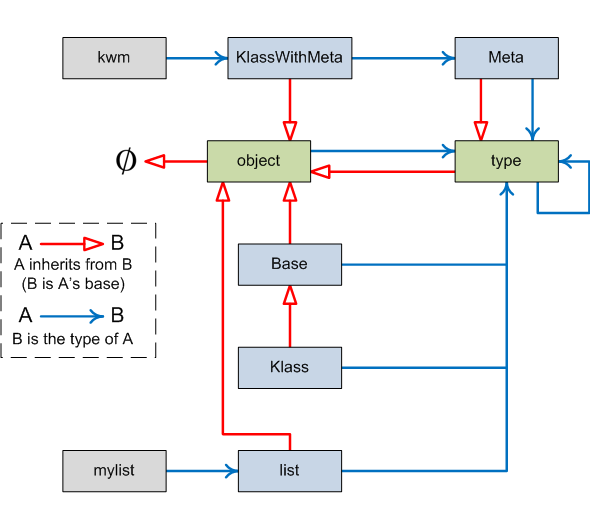

In [32]:
print(object.__class__)
print(type.__class__)
print(object.__name__)
print(type.__name__)
print(object.__bases__)
print(type.__bases__)


<class 'type'>
<class 'type'>
object
type
()
(<class 'object'>,)


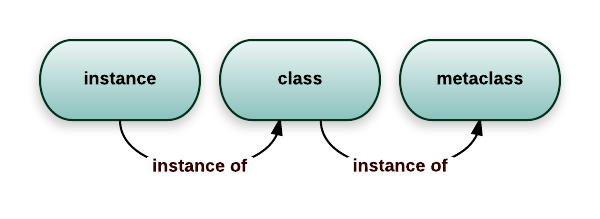

type is default metaclass

In [33]:
name = "Otus"
bases = (object,)
class_attributes = {"cool": True}

cls = type(name, bases, class_attributes)

obj = cls()
print(cls, cls.__dict__, obj.__class__)

<class '__main__.Otus'> {'cool': True, '__module__': '__main__', '__dict__': <attribute '__dict__' of 'Otus' objects>, '__weakref__': <attribute '__weakref__' of 'Otus' objects>, '__doc__': None} <class '__main__.Otus'>


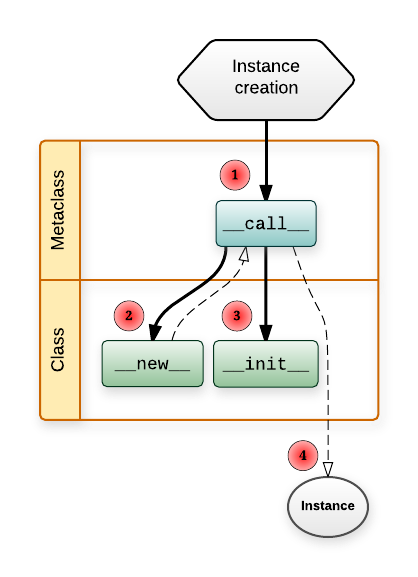

In [1]:
class OtusMeta:
    def __new__(meta, name, bases, dct):
        print('-----------------------------------')
        print("creating class", name)
        print(meta)
        print(bases)
        print(dct)
        return super(OtusMeta, meta).__new__(meta, name, bases, dct)

    def __init__(cls, name, bases, dct):
        print('-----------------------------------')
        print("Initializing class", name)
        print(cls)
        print(bases)
        print(dct)
        super(OtusMeta, cls).__init__(name, bases, dct)

    def __call__(cls, *args, **kwargs):
        print('-----------------------------------')
        print('__call__ of %s' % cls)
        print('__call__ *args=%s, **kwargs=%s' % (args, kwargs))
        return super(OtusMeta, cls).__call__(*args, **kwargs)

class Otus(object):
    __metaclass__ = OtusMeta

    def __init__(self, min_woos, silent=False):
        self.min_woos = min_woos
    
    def woo(self, n):
        if self.silent:
            return
        for _ in xrange(max(self.min_woos, n)):
            print("Woo!")

    started = True


-----------------------------------
creating class Otus
<class '__main__.OtusMeta'>
(<type 'object'>,)
{'started': True, '__module__': '__main__', '__metaclass__': <class '__main__.OtusMeta'>, 'woo': <function woo at 0x10a84d488>, '__init__': <function __init__ at 0x10a84d410>}
-----------------------------------
Initializing class Otus
<class '__main__.Otus'>
(<type 'object'>,)
{'started': True, '__module__': '__main__', '__metaclass__': <class '__main__.OtusMeta'>, 'woo': <function woo at 0x10a84d488>, '__init__': <function __init__ at 0x10a84d410>}


In [2]:
Otus(-1, silent=False)

-----------------------------------
__call__ of <class '__main__.Otus'>
__call__ *args=(-1,), **kwargs={'silent': False}


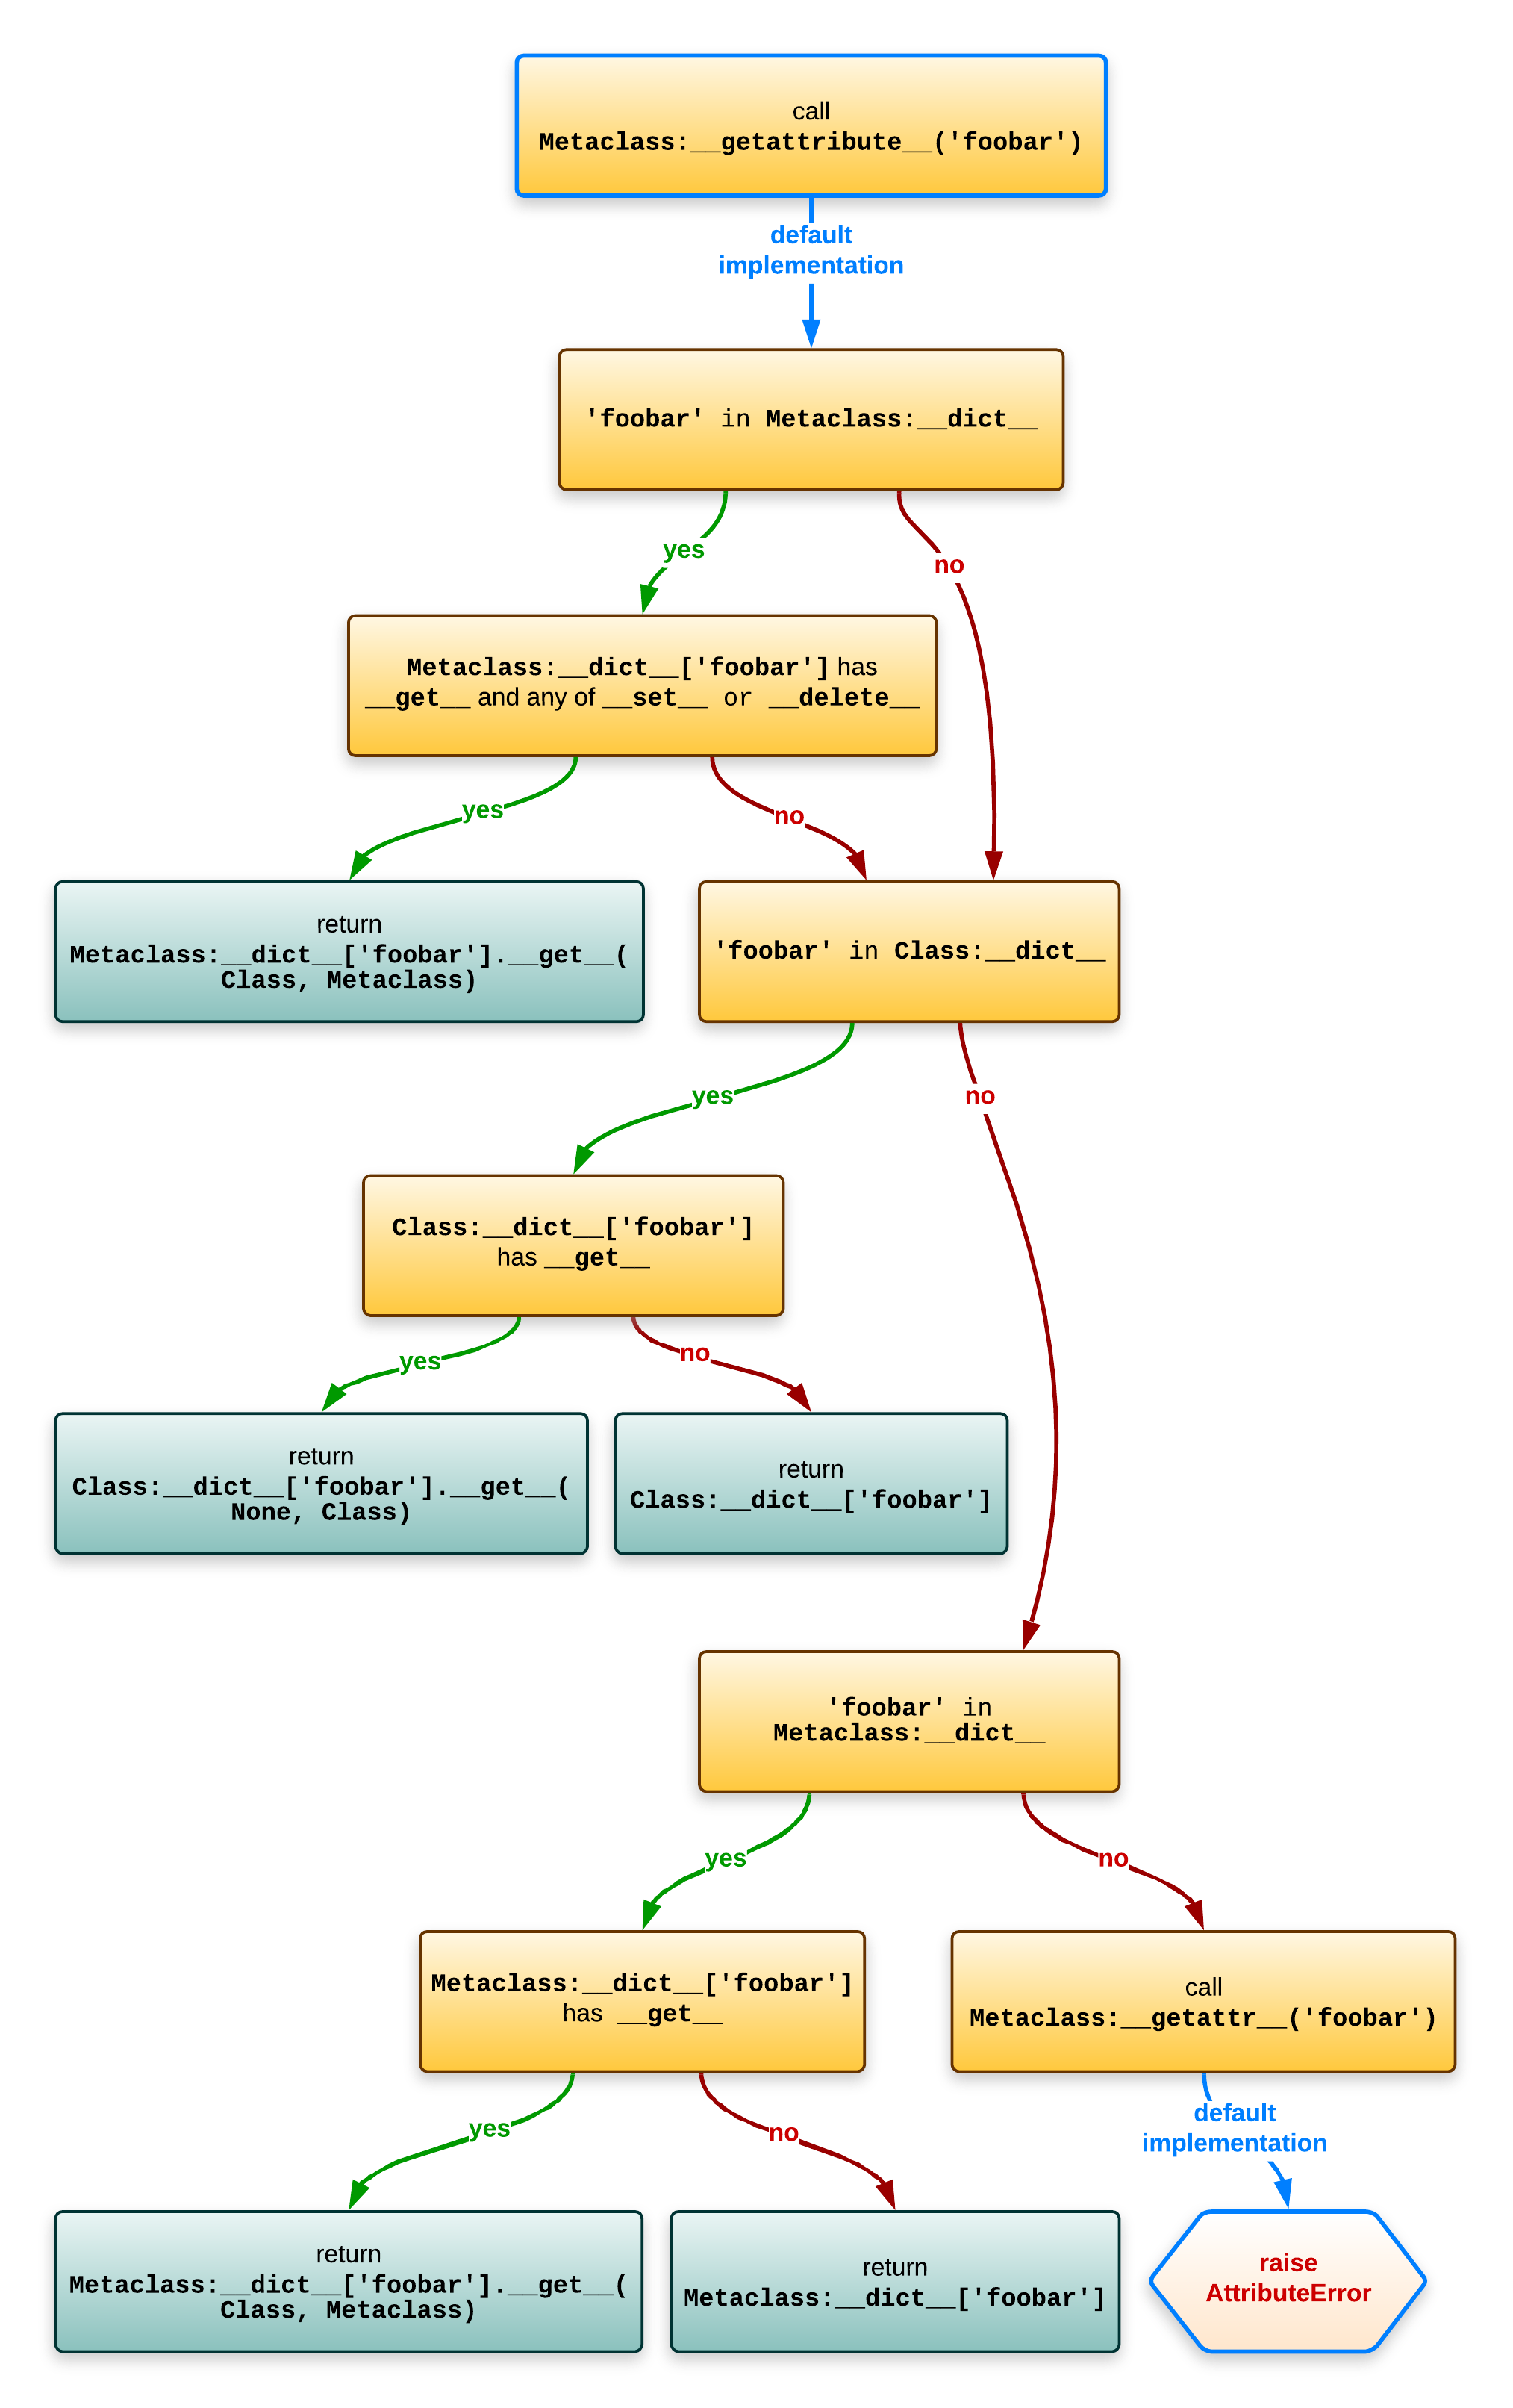

`Template` can be inherited to provide a custom delimiter and ID pattern, or the whole regex. The metaclass makes sure that these get converted into a compiled regex pattern at class creation time, so this is an optimization of a sort.

In [130]:
import re as _re

class _TemplateMetaclass(type):
    pattern = r"""
    %(delim)s(?:
      (?P<escaped>%(delim)s) |   # Escape sequence of two delimiters
      (?P<named>%(id)s)      |   # delimiter and a Python identifier
      {(?P<braced>%(id)s)}   |   # delimiter and a braced identifier
      (?P<invalid>)              # Other ill-formed delimiter exprs
    )
    """

    def __init__(cls, name, bases, dct):
        super(_TemplateMetaclass, cls).__init__(name, bases, dct)
        if 'pattern' in dct:
            pattern = cls.pattern
        else:
            pattern = _TemplateMetaclass.pattern % {
                'delim' : _re.escape(cls.delimiter),
                'id'    : cls.idpattern,
                }
        cls.pattern = _re.compile(pattern, _re.IGNORECASE | _re.VERBOSE)


class Template:
    """A string class for supporting $-substitutions."""
    __metaclass__ = _TemplateMetaclass

    delimiter = '$'
    idpattern = r'[_a-z][_a-z0-9]*'

    def __init__(self, template):
        self.template = template


Django Forms

In [ ]:
class DeclarativeFieldsMetaclass(MediaDefiningClass):
    """
    Metaclass that collects Fields declared on the base classes.
    """
    def __new__(mcs, name, bases, attrs):
        # Collect fields from current class.
        current_fields = []
        for key, value in list(attrs.items()):
            if isinstance(value, Field):
                current_fields.append((key, value))
                attrs.pop(key)
        current_fields.sort(key=lambda x: x[1].creation_counter)
        attrs['declared_fields'] = OrderedDict(current_fields)

        new_class = (super(DeclarativeFieldsMetaclass, mcs)
            .__new__(mcs, name, bases, attrs))

        # Walk through the MRO.
        declared_fields = OrderedDict()
        for base in reversed(new_class.__mro__):
            # Collect fields from base class.
            if hasattr(base, 'declared_fields'):
                declared_fields.update(base.declared_fields)

            # Field shadowing.
            for attr, value in base.__dict__.items():
                if value is None and attr in declared_fields:
                    declared_fields.pop(attr)

        new_class.base_fields = declared_fields
        new_class.declared_fields = declared_fields

        return new_class


class Form(six.with_metaclass(DeclarativeFieldsMetaclass, BaseForm)):
    "A collection of Fields, plus their associated data."
    # This is a separate class from BaseForm in order to abstract the way
    # self.fields is specified. This class (Form) is the one that does the
    # fancy metaclass stuff purely for the semantic sugar -- it allows one
    # to define a form using declarative syntax.
    # BaseForm itself has no way of designating self.fields.

Continuing example at "Descriptors" section

In [111]:
class Descriptor:
    def __init__(self):
        self.label = None
        
    def __get__(self, instance, owner):
        print('__get__. Label = %s' % self.label)
        return instance.__dict__.get(self.label, None)
    
    def __set__(self, instance, value):
        print('__set__')
        instance.__dict__[self.label] = value

# Because descriptor labels match the variable name they are assigned to, 
# we can use metaclasses to take care of this bookkeeping automatically
class DescriptorOwner(type):
    def __new__(cls, name, bases, attrs):
        # find all descriptors, auto-set their labels
        for n, v in attrs.items():
            if isinstance(v, Descriptor):
                v.label = n
        return super(DescriptorOwner, cls).__new__(cls, name, bases, attrs)

        
class Foo(metaclass=DescriptorOwner):
    x = Descriptor()
    
f = Foo()
f.x = 10
print(f.x)

__set__
__get__. Label = x
10


### References

* http://eli.thegreenplace.net/2011/08/14/python-metaclasses-by-example
* https://blog.ionelmc.ro/2015/02/09/understanding-python-metaclasses/
* https://stackoverflow.com/questions/100003/what-is-a-metaclass-in-python
* https://www.python.org/download/releases/2.2.3/descrintro/#metaclasses
* https://www.youtube.com/watch?v=sPiWg5jSoZI
* http://ivansmirnov.io/python-metaclasses/

### Summary

* use at your own risk only if you absolutely must
* dont forget that subclasses inherit the metaclass

## Design Patterns

* summary of a frequent design problem + structure of a solution to that problem (+ pros and cons, alternatives, ...), and:
    * A NAME (much easier to retain/discuss!)
* "descriptions of communicating objects and classes customized to solve a general design problem in a particular context"
* __NOT__:
    * a data structure
    * algorithm
    * domain-specific system architecture
    * programming-language/library feature
* __MUST__ be studied in a language's context!
* __MUST__ supply Known Uses

__Categories__:
* Creational
    * ways and means of object instantiation
* Structural
    * mutual composition of classes or objects (the Facade DP is Structural)
* Behavioral
    * how classes or objects interact and distribute responsibilities among them

__Core Principles__
* program to an interface, not to an implementation
    * done with duck typing in Python
* favor object composition over class inheritance
    * in Python: __hold__, or __wrap__
    * inherit only when it's really convenient
        * expose all methods in base class (reuse + usually override + maybe extend)
        * very strong coupling

* __Hold__: object O has subobject S as an attribute (maybe property)
    * use self.S.method or O.S.method
* __Wrap__: hold (often via private name) plus delegation 
    * use O.method
        * explicit (def method(self...)...self.S.method)
        * automatic (delegation in \__getattr\__)
    

In [1]:
class RestrictingWrapper:
    def __init__(self, w, block):
        self._w = w
        self._block = block
    def __getattr__(self, n):
        if n in self._block:
            raise AttributeError, n
        return getattr(self._w, n)

__Creational Patterns__

Singleton Pattern

In [9]:
class Singleton:
    def __new__(cls, *args, **kwargs):
        if not hasattr(cls, '_inst'):
            cls._inst = super(Singleton, cls).__new__(cls, *args, **kwargs)
        return cls._inst

# subclassing is a problem
class Foo(Singleton): pass
class Bar(Foo): pass
f = Foo()
b = Bar() 

* is b a Singleton or Bar instance? What if we change order in which objects created?
* this problem is intrinsic to any Singleton
* could overcome subclassing problem by turning Singleton to metaclass
* or using Borg (Monostate)

In [8]:
class Borg:
    _shared_state = {}
    def __new__(cls, *args, **kwargs):
        obj = super(Borg, cls).__new__(cls, *args, **kwargs)
        obj.__dict__ = cls._shared_state
        return obj

# subclassing is no problem
class Foo(Borg):
    pass
class Bar(Foo):
    pass
class Baz(Foo):
    _shared_state = {}

* this still could break if child class overrides \__getattr\__
* Python's module is already a singleton

__Structural Patterns__

Adapater Pattern
* socket._fileobject: treats socket like file object (with a lot of buffering)
* StringIO: treats stings and unicode as file object

In [ ]:
class StringIO:
    def __init__(self, buf = ''):
        # Force self.buf to be a string or unicode
        if not isinstance(buf, basestring):
            buf = str(buf)
        self.buf = buf
        self.len = len(buf)
        self.buflist = []
        self.pos = 0
        self.closed = False
        self.softspace = 0

    def tell(self):
        _complain_ifclosed(self.closed)
        return self.pos

    def read(self, n = -1):
        _complain_ifclosed(self.closed)
        if self.buflist:
            self.buf += ''.join(self.buflist)
            self.buflist = []
        if n is None or n < 0:
            newpos = self.len
        else:
            newpos = min(self.pos+n, self.len)
        r = self.buf[self.pos:newpos]
        self.pos = newpos
        return r

Facade Pattern
* os.path: basename, dirname facade for split + indexing; isdir (&c) facade for os.stat + stat.S_ISDIR (&c)

In [17]:
import sys, errno

_names = sys.builtin_module_names

__all__ = ["altsep", "curdir", "pardir", "sep", "extsep", "pathsep", "linesep",
           "defpath", "name", "path", "devnull",
           "SEEK_SET", "SEEK_CUR", "SEEK_END"]

def _get_exports_list(module):
    try:
        return list(module.__all__)
    except AttributeError:
        return [n for n in dir(module) if n[0] != '_']


if 'posix' in _names:
    name = 'posix'
    linesep = '\n'
    from posix import *
    try:
        from posix import _exit
    except ImportError:
        pass
    import posixpath as path

    import posix
    __all__.extend(_get_exports_list(posix))
    del posix

elif 'nt' in _names:
    name = 'nt'
    linesep = '\r\n'
    from nt import *
    try:
        from nt import _exit
    except ImportError:
        pass
    import ntpath as path

    import nt
    __all__.extend(_get_exports_list(nt))
    del nt

__Behavioral Patterns__

Template Pattern
* Queue

In [18]:
class AbstractBase(object):
    def organizing_method(self):
        self.do_this()
        self.do_that()


class Concrete(AbstractBase):
    def do_this(self):
        pass
    def do_that(self):
        pass

In [19]:
class Queue:
    def put(self, item, block=True, timeout=None):
        self.not_full.acquire()
        try:
            if self.maxsize > 0:
                if not block:
                    if self._qsize() == self.maxsize:
                        raise Full
                elif timeout is None:
                    while self._qsize() == self.maxsize:
                        self.not_full.wait()
                elif timeout < 0:
                    raise ValueError("'timeout' must be a non-negative number")
                else:
                    endtime = _time() + timeout
                    while self._qsize() == self.maxsize:
                        remaining = endtime - _time()
                        if remaining <= 0.0:
                            raise Full
                        self.not_full.wait(remaining)
            self._put(item)
            self.unfinished_tasks += 1
            self.not_empty.notify()
        finally:
            self.not_full.release()


class LifoQueue(Queue):
    def _put(self, item):
        self.queue.appendleft(item)


### References

* https://ru.wikipedia.org/wiki/YAGNI
* https://en.wikipedia.org/wiki/Law_of_Demeter
* https://github.com/faif/python-patterns
* http://shop.oreilly.com/product/9780596007126.do
* https://www.youtube.com/watch?v=4KZx8bATBFs

### Summary

* don't think about using some pattern think about solving a problem
* patterns  come useful when discussing solution